# Demo

### Introduction

The PowerPlanner package contains algorithms and classes for shortest path algorithms for power infrastructure layout. This is a demonstration of the usage of the provided functions. An artificial example is used which can be find in data/test_1.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pickle
import json
from power_planner import graphs

### Load data

In [2]:
# Input path with test data
IN_PATH = "data/test_data_1_2.dat"
SCALE_PARAM = 2
    
# READ DATA
with open(IN_PATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, edge_inst, instance_corr, config) = data

### Configuration

The config namespace contains metadata about the data pre-processing and hyperparameters for the graph processing

In [9]:
print("Data configuration:\n----------------")
for key in vars(config.data).keys():
    print(key, ":", vars(config.data)[key])
print("\n\n----------------")
print("Graph configuration:\n----------------")
for key in vars(config.graph).keys():
    print(key, ":", vars(config.graph)[key])

Data configuration:
----------------
HARD_CONS_PATH : hard_constraints
CORR_PATH : corridor/Corridor.tif
COST_PATH : COSTSURFACE.tif
START_PATH : start_point/Start
DEST_PATH : dest_point/Destination
WEIGHT_CSV : layer_weights.csv
RASTER : 10
SCENARIO : 1
PYLON_DIST_MIN : 150
PYLON_DIST_MAX : 250
CABLE_FORBIDDEN : 1
ONE_CLASS : 0
PERC_PAD : -1
EMERGENCY_DIST : -1


----------------
Graph configuration:
----------------
CSV_TIMES : ../outputs/time_tests.csv
MAX_ANGLE : 1.57079632679489
MAX_ANGLE_LG : 1.57079632679489
VERBOSE : 1
GTNX : 1
ANGLE_WEIGHT : 0.4
EDGE_WEIGHT : 0.33
KSP : 5
PYLON_DIST_MIN : 3.0
PYLON_DIST_MAX : 5.0
transform_matrix : | 10.00, 0.00, 2598830.06|
| 0.00,-10.00, 1261728.05|
| 0.00, 0.00, 1.00|
scale : 2
orig_start : [1154   34]
orig_dest : [1537 3093]
dest_inds : [307 618]
start_inds : [230   6]
layer_classes : ['Bau/Unterhalt', 'Raumplanung', 'Umwelt-/Biotopschutz']
class_weights : [1, 1, 1]


#### Change configuration by setting config variables

In [11]:
config.graph.ANGLE_WEIGHT = 0.1

### Instance:

The instance defines the resistances for placing a **pylon** in a particular cell.
Shape is number of categories x dimensions of resistance map

In [19]:
print("Shape:", instance.shape)

Shape: (3, 418, 624)


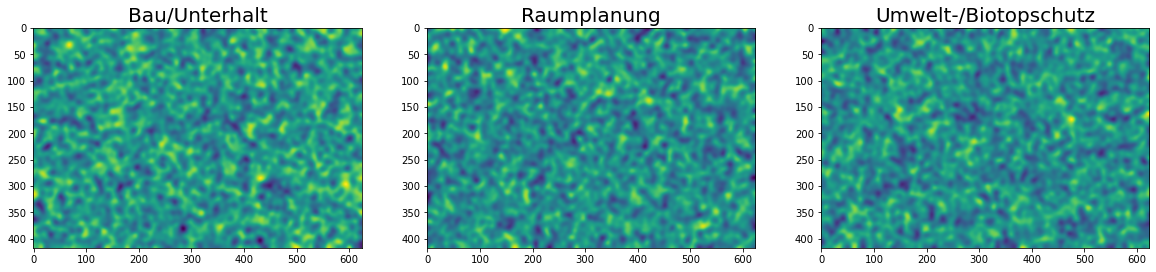

In [14]:
n_categories = len(instance)
plt.figure(figsize=(20,10))
for i in range(n_categories):
    plt.subplot(1,n_categories,i+1)
    plt.imshow(instance[i])
    plt.title(config.graph.layer_classes[i], fontsize=20)
plt.show()

### Edge instance:

The edge instance defines the resistances for placing a **cable** above a particular cell.

In [18]:
print("Shape:", edge_inst.shape)

Shape: (3, 418, 624)


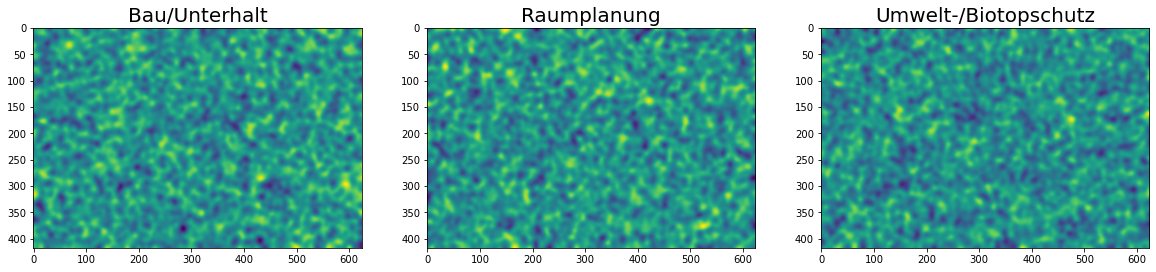

In [15]:
n_categories = len(edge_inst)
plt.figure(figsize=(20,10))
for i in range(n_categories):
    plt.subplot(1,n_categories,i+1)
    plt.imshow(edge_inst[i])
    plt.title(config.graph.layer_classes[i], fontsize=20)
plt.show()

### Corridor

The corridor defines the project region, excluding forbidden regions (where no pylon can be placed).

Shape is only the dimensions of the resistance map

In [20]:
print("Shape:", instance_corr.shape)

Shape: (418, 624)


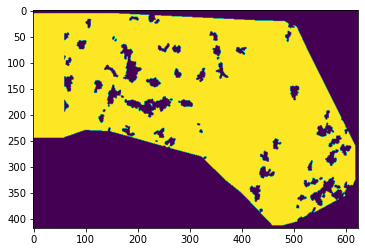

In [21]:
plt.imshow(instance_corr)

### Initialize graph

In [3]:
graph = graphs.ImplicitLG(instance, instance_corr)

### Single shortest path

A function ```single_sp``` takes the configuration as input and deals with constructing the graph and computing the shortest path

In [4]:
path, path_costs, cost_sum = graph.single_sp(edge_inst, **vars(config.graph))

1) Initialize shifts and instance (corridor)
cost weights [0.28571429 0.23809524 0.23809524 0.23809524]
instance shape (418, 624)
memory taken (dists shape): 7303296
2) Initialize distances to inf and predecessors
time topo sort: 2.058
stack length 150014
Computed edge instance
58.25877961033236
time edges: 7.656
3) Compute source shortest path tree
number of vertices and edges: 260832 7303296
4) shortest path 58.25877961033239


#### Dists and predecessors:

The shortest path algorithm above fill two arrays, ```dists``` and ```preds``` referring to the distance of the source vertex to each edge and the predecessor of each edge. Since each vertex (aka raster cell) has exactly the same number of incoming egdes, ```dists``` and ```preds``` are implemented as 3D array: The shape is the number of neighbors x the dimensions of the resistance map:

In [8]:
print("Shape:", graph.dists.shape)
print("Number of neighbors per vertex (=shifts):", len(graph.shifts))
print("Neighbor shifts:", graph.shifts)

Shape: (28, 418, 624)
Number of neighbors per vertex (=shifts): 28
Neighbor shifts: [(-4, 1), (-4, 2), (-4, 3), (-3, 1), (-3, 2), (-3, 3), (-3, 4), (-2, 3), (-2, 4), (-1, 3), (-1, 4), (0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0)]


Source: [230   6] , Target: [307 618]


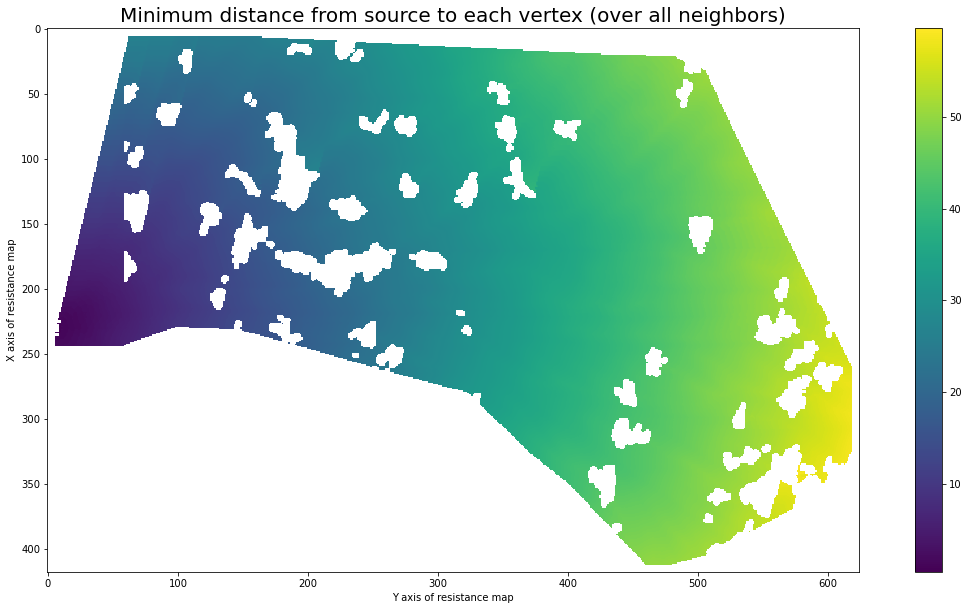

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(np.min(graph.dists, axis=0))
plt.title("Minimum distance from source to each vertex (over all neighbors)", fontsize=20)
plt.colorbar()
plt.ylabel("X axis of resistance map")
plt.xlabel("Y axis of resistance map")
plt.show()
print("Source:", config.graph.start_inds, ", Target:", config.graph.dest_inds)

#### Shortest path:

The shortest path can be plotted on the instance, where the instance is now the weighted sum of the category resistances.

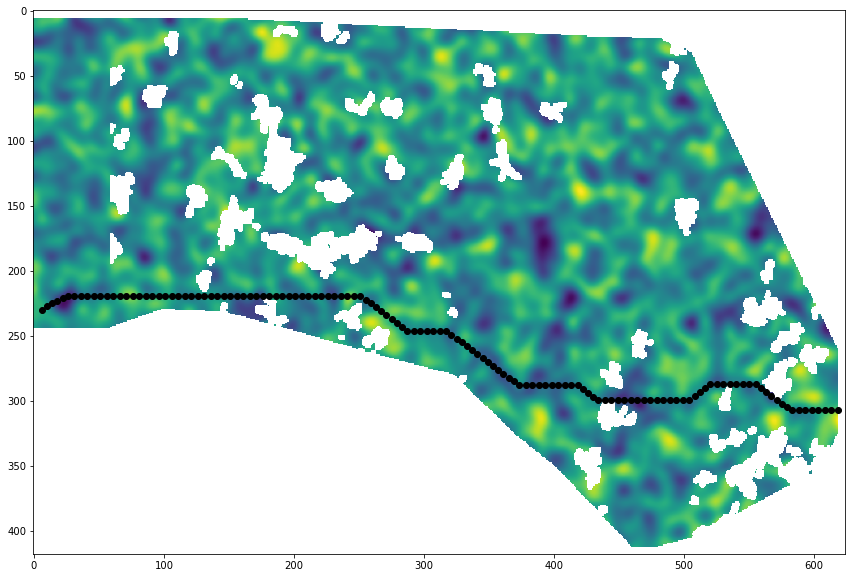

In [16]:
path = np.asarray(path)
plt.figure(figsize=(20,10))
plt.imshow(graph.instance)
plt.scatter(path[:,1], path[:,0], c="black")
plt.show()

# Shortest path trees

For all further processing and variants, the shortest path trees from source and from the target vertex are required. Again, there is a function sp_trees implemented that handles all the computation, given the config variables

### Compute SP trees

The resulting path is the same path as from the other direction. In addition to the ```dists``` array, now a second array is computed named ```dists_ba```, indicating the distances from the other direction (same for the predecessors).

In [17]:
path, path_costs, cost_sum = graph.sp_trees(edge_inst, **vars(config.graph))

1) Initialize shifts and instance (corridor)
cost weights [0.28571429 0.23809524 0.23809524 0.23809524]
instance shape (418, 624)
memory taken (dists shape): 7303296
2) Initialize distances to inf and predecessors
time topo sort: 0.101
stack length 150014
Computed edge instance
58.25877961033236
time edges: 6.175
3) Compute source shortest path tree
number of vertices and edges: 260832 7303296
4) shortest path 58.25877961033239
time shortest_path_tree: 7.43


## K diverse shortest paths

Several algorithms were implemented for finding a diverse set of short paths. The ```KSP``` class takes a graph as input (**NOTE: SP trees must have been computed previously**) to compute the KSP on this graph.

In [19]:
from power_planner.ksp import KSP
from power_planner.plotting import plot_k_sp
ksp = KSP(graph)

#### Laplace (presented as corridor-approach): Put penalty in corridor around previously computed paths

/Users/ninawiedemann/Desktop/thesis/power_planner.nosync/power_planner/ksp.py:18: RuntimeWarning: invalid value encountered in subtract
  self.graph.dists + self.graph.dists_ba - self.graph.instance -


Laplace KSP time: 0.773


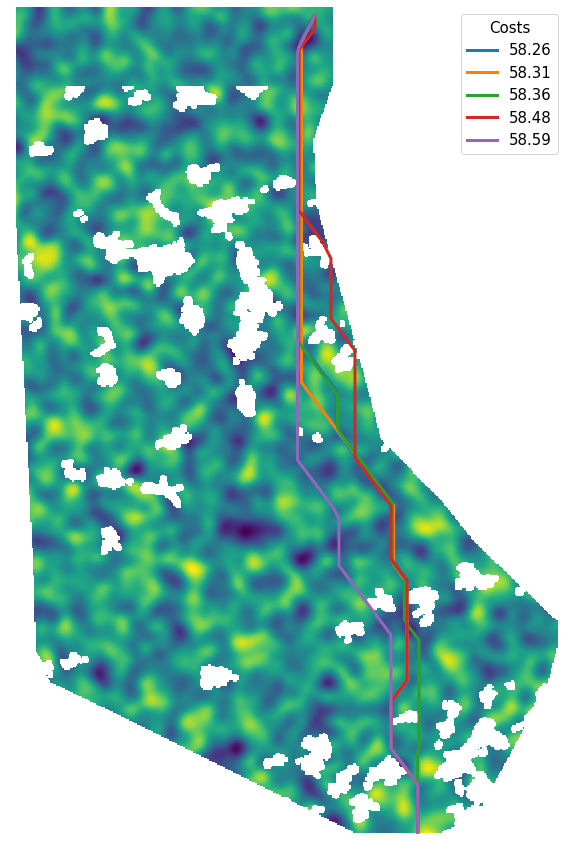

In [21]:
out_laplace = ksp.laplace(5) # 5 is the number of paths we want to have
plot_k_sp(out_laplace, graph.instance)

#### Max vertex: Find next path where the maximum eucledian distance is above a given threshold

/Users/ninawiedemann/Desktop/thesis/power_planner.nosync/power_planner/ksp.py:18: RuntimeWarning: invalid value encountered in subtract
  self.graph.dists + self.graph.dists_ba - self.graph.instance -


3418 expanded 4
max vertex time: 4.122


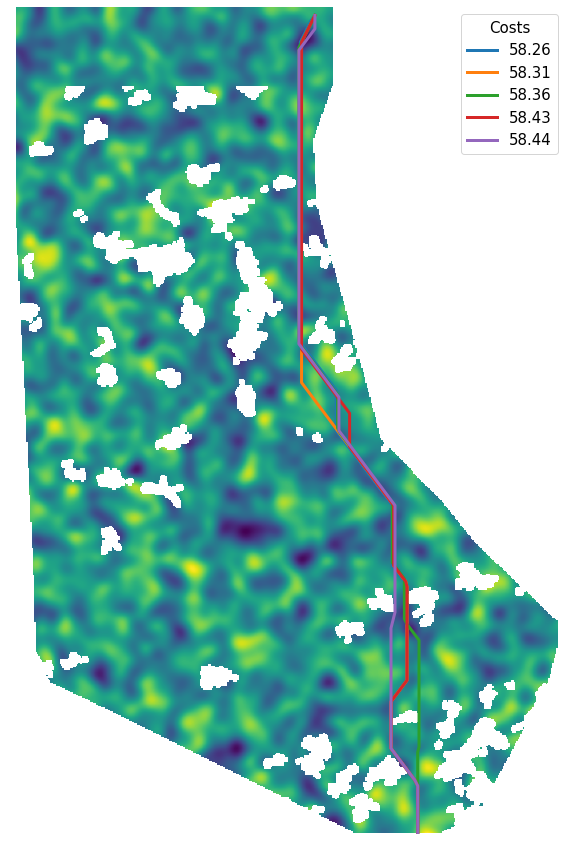

In [23]:
out_max_vertex = ksp.max_vertex_ksp(5)
plot_k_sp(out_max_vertex, graph.instance)

## Alternatives:

The ```AlternativePaths``` class implements methods to find a replacement path avoiding one edge in the shortest path, or forcing the path through a window

In [20]:
from power_planner.alternative_paths import AlternativePaths

In [26]:
alt = AlternativePaths(graph)

#### Force path through window

In [27]:
rect = (100,120,250,300) # (upper left x, bottom right x, upper left y, bottom right y)
alt_path, alt_path_costs, alt_cost_sum = alt.path_through_window(*rect)

/Users/ninawiedemann/Desktop/thesis/power_planner.nosync/power_planner/alternative_paths.py:189: RuntimeWarning: invalid value encountered in subtract
  self.graph.dists + self.graph.dists_ba - self.graph.instance -


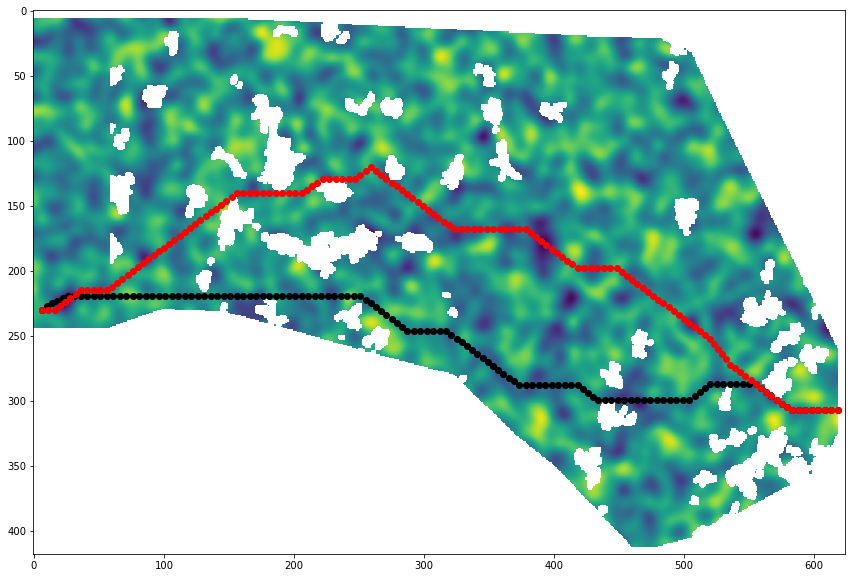

In [29]:
alt_path = np.asarray(alt_path)
plt.figure(figsize=(20,10))
plt.imshow(graph.instance)
plt.scatter(path[:,1], path[:,0], c="black")
plt.scatter(alt_path[:,1], alt_path[:,0], c="red")
plt.show()